In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from datetime import datetime, date 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=18,10

In [4]:
def juro_selic():
    codigo_serie = 432 # indice IPCA mensal
    url = f'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados/?formato=json'
    juro_selic = pd.read_json(url)
    juro_selic = juro_selic.iloc[-1, 1]
    return juro_selic

def getTitulos():
    url = 'https://apiapex.tesouro.gov.br/aria/v1/sistd/custom/ultimaRentabilidadeCSV'
    titulos = pd.read_csv(url, sep=";", encoding="latin1")
    titulos[['Últ. 30 dias','Mêsanterior','No ano','12 meses','Compra','Venda']] = titulos[['Últ. 30 dias','Mêsanterior','No ano','12 meses','Compra','Venda']].apply(lambda x: x.str.replace(',','.'))

    titulos.query("Compra != '-'", inplace=True)
    titulos['Vencimento'] = pd.to_datetime(titulos['Vencimento'],format="%d/%m/%Y")
    titulos.reset_index(drop=True,inplace=True)
    for i in range(len(titulos)):
        titulos['Títulos'][i] = f"{titulos['Títulos'][i]} {titulos['Vencimento'][i].year}"

    return titulos

In [15]:
def calcular_poupanca(aplicacao, aportes, nome_titulo, dataset=getTitulos(), juro_selic=juro_selic()):
    # Tirei as informações daqui de como calcular https://www.idinheiro.com.br/calculadoras/calculadora-rendimento-da-poupanca/

    df = dataset[dataset["Títulos"] == nome_titulo]

    # Pegando a quantidade de meses
    startdt=pd.to_datetime(datetime.now().date())
    enddt = df["Vencimento"].iloc[0]
    len(pd.date_range(start=startdt,end=enddt,freq='M'))

    tempo = int(len(pd.date_range(start=startdt,end=enddt,freq='M')) - 1)

    if juro_selic < 8.5:
        remuneracao = (juro_selic['valor'].values[0]*70/100/12)/100
        remuneracao = round(remuneracao, 6)
    else:
        remuneracao = (0.5)/100 
        remuneracao = round(remuneracao, 6)
        
    calculos = 0
    rendimentos = []

    while tempo > calculos:
        valor_futuro = (aportes * (((1+remuneracao)**(calculos))-1)) / remuneracao
        redimento = round((aplicacao * ((1+remuneracao) ** calculos)) + valor_futuro, 2)
        rendimentos.append(redimento)
        calculos = calculos + 1

    return rendimentos


C:\Users\Rado\AppData\Local\Temp/ipykernel_14252/577638874.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titulos['Títulos'][i] = f"{titulos['Títulos'][i]} {titulos['Vencimento'][i].year}"


In [26]:
datelist = pd.date_range(datetime.today().date(), periods=32, freq= 'M').tolist()

In [27]:
rendimentos = calcular_poupanca(aplicacao=1000, aportes=50, nome_titulo='Tesouro Selic 2024')

In [22]:
len(rendimentos)

32

<AxesSubplot:>

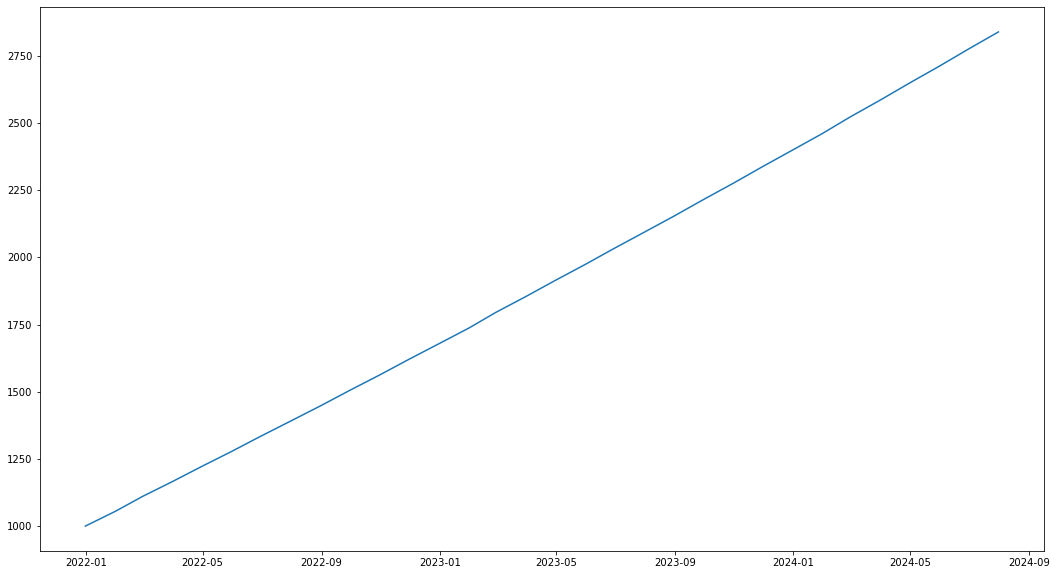

In [28]:
sns.lineplot(x = datelist, y = rendimentos)